Peter Haas, Kiel University, 16 April 2021

This program calculates Moho depth and density contrasts based on inversion of satellite gravity gradient data for the African Continent. Moho depth and density contrasts are constrained by a new regionalization map for the African continent, based on the seismic tomography model AF2019, and seismic data bases of Globig et al. 2016 and USGS data. For more information on the constraining data, see here:
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JB012972 (Supporting information)
https://nlscelli.wixsite.com/ncseismology/models

The inversion is split in two parts: First, varying density contrasts of individual tectonic domains, second varying the density contrasts for cratons only.

The following program is designed for a sample region in Africa. This version is preliminary and comments will be updated soon. When using, please cite the corresponding paper of Haas et al. 2021, which is submitted for Frontiers in Earth Science:
Haas, P., J. Ebbing, N. Celli and P. Rey - Two-step gravity inversion reveals variable architecture of African cratons

Load the Python packages that are required for the inversion

In [1]:
import numpy as np

from matplotlib import cm,path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.font_manager as font_manager
from scipy.interpolate import griddata
import progressbar
import os

# Here you have to include the path where the "proj4" is located (essential to use the Basemap package)
os.environ['PROJ_LIB'] = r'C:\Users\Peter\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'
from mpl_toolkits.basemap import Basemap

# Specific functions designed for the gravity inversion
from grad_inv_functions_AFR import *
from topo_corr import *

In [2]:
lon_min=5 #Define coordinates of study area
lon_max=37 
lat_min=-30
lat_max=3

dx=1.0 # define grid cell size (should be 1.0 degree)
dy=1.0

# Define Coordinate Grids
lon=np.arange(lon_min,lon_max+dx,dx)
lat=np.arange(lat_min,lat_max+dy,dy)
longr,latgr = np.meshgrid(lon,lat)
lon=longr.flatten() 
lat=latgr.flatten()
height_km=225
heights=np.ones(len(lon))*height_km*1000

data_name="Moho_Africa" # Define Prefix name of output files 
mode="single" # keep those values
component='gzz' 
farfield='no'
sediment='no' 

In [3]:
# The next values define density contrast, reference Moho depth and smoothing. The values may be changed, 
# but are recommended to keep fixed
dens_min,dens_max,dens_inc=250.0,500.0,50 # select density contrasts
ref_moho=-32000.0 # select reference Moho depth
beta=1e-4 # select range and increment of smoothing parameter 

dens_range=np.arange(dens_min,dens_max+0.1,dens_inc) #defines range and increment of density contrast
dens_init=dens_range[0]

# Define number of point masses the tesseroids are converted to. Should not be higher than 2
point_mass_number=1

In [4]:
# Define study area
area = (lat.min(), lat.max(), lon.min(), lon.max())
overlap_seis=2.0
area_seis = (lat.min()+overlap_seis, lat.max()-overlap_seis, lon.min()+overlap_seis, lon.max()-overlap_seis)
shape=np.array((abs(lat_max-lat_min)/dy+1,abs(lon_max-lon_min)/dx+1))
shape=shape.astype(int)

Set parameters for topographic correction

In [5]:
# Define area for Bouguer anomaly with overlap to avoid edge effects
overlap_gravity=5.0
area2 = (lat.min()-overlap_gravity, lat.max()+overlap_gravity, lon.min()-overlap_gravity, lon.max()+overlap_gravity)

In [6]:
# Load and prepare seismic data
seismic_stations_as=np.loadtxt("Seismic_stations_UGSS_Globig_binned_AS_binned_IDW_1degree.txt")
seismic_stations_as=cut_data_to_study_area(seismic_stations_as,area_seis)
seismic_stations_as=seismic_stations_as[np.lexsort((seismic_stations_as[:,0],seismic_stations_as[:,1]))]

seismic_stations_rf=np.loadtxt("Seismic_stations_UGSS_Globig_binned_RF_binned_IDW_1degree.txt")
seismic_stations_rf=cut_data_to_study_area(seismic_stations_rf,area_seis)
seismic_stations_rf=seismic_stations_rf[np.lexsort((seismic_stations_rf[:,0],seismic_stations_rf[:,1]))]

In [7]:
#Prepare Regularization
dmatrix_init=Doperator(shape,dx,dy)
smooth_matrix=np.eye(lon.size)*beta
dmatrix=dmatrix_init*beta

In [8]:
# Load tectonic regionalization
tec_units=np.loadtxt("Reg_AF2019_n6.txt")
tec_units=cut_data_to_study_area(tec_units,area)
tec_units=tec_units[np.lexsort((tec_units[:,0],tec_units[:,1]))]

# Prepare matrix for estimated density contrasts
number_of_units=len(np.unique(tec_units[:,2]))
dens_mat=create_density_combinations(dens_range,number_of_units-1)
dens_mat=np.vstack((np.ones(len(dens_mat))*400,dens_mat.T)).T

rms_matrix_as=np.zeros((dens_range.size**number_of_units,number_of_units+5))
rms_matrix_rf=np.copy(rms_matrix_as)

We make use of the colourblind-friendly colour maps developed by Fabio Crameri. For more information see: https://www.fabiocrameri.ch/colourmaps/

The regionalization colour map is adapted to previously published regionalizations.

In [9]:
# Load colorbars
batlow=np.loadtxt("batlow.txt")
cmp_batlow = ListedColormap(batlow)
vik=np.loadtxt("vik.txt")
cmp_vik = ListedColormap(vik)
vik=np.loadtxt("turku.txt")
cmp_turku = ListedColormap(vik)

# Define Colour map of regionalization
rgb_values=np.array(([255.0,255.0,255.0],[0.0,64.0,255.0],[167.0,186.0,209.0],
                     [204.0,3.0,0.0],[255.0,187.0,51.0],[102.0,51.0,0.0],
                     [174.0,234.0,180.0],[61.0,204.0,75.0],[32.0,121.0,41.0]))/255
cmp_regionalization = ListedColormap(rgb_values)

Define plotting functions

In [10]:
area_plot = (area[2],area[3],area[0],area[1])

bm = Basemap(projection='cyl', 
             llcrnrlon=area_plot[0], urcrnrlon=area_plot[1], 
             llcrnrlat=area_plot[2], urcrnrlat=area_plot[3],
             lon_0=0.5*(area_plot[0] + area_plot[1]), lat_0=0.5*(area_plot[3] + area_plot[2]), 
             resolution='l')

In [11]:
def plot_reg(lon, lat, data, seismic_stations1, seismic_stations2, area, vmin, vmax, cblabel='km', levels=60,ranges=True):
    plt.rcParams.update({'font.size': 16})
    
    x=np.arange(area[0],area[1]+1,dx)
    y=np.arange(area[2],area[3]+1,dy)
    X, Y = np.meshgrid(x, y)
    points=np.vstack((lon,lat)).T
    grid_z0 = griddata(points, data, (X, Y), method='nearest')
    fig = plt.figure(figsize=(10, 7))
    ax = plt.subplot(111)
    bm.pcolor(X, Y, grid_z0, cmap=cmp_regionalization, vmin=vmin, vmax=vmax)
    bm.scatter(seismic_stations2[:,0],seismic_stations2[:,1],marker='v',s=14,color='magenta',label='RF')    
    bm.scatter(seismic_stations1[:,0],seismic_stations1[:,1],marker='^',s=14,color='k',label='AS')  
    bm.drawmeridians(np.arange(-180, 180, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-80, 80, 10), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    m = plt.cm.ScalarMappable(cmap=cmp_regionalization)
    m.set_array(data)
    m.set_clim(vmin, vmax)
    labels=["Craton","Precam-" + "\n" + "brian" + "\n" + "Fold Belt","Phane-" + "\n" + "rozoic","Ridges","Oceanic","Oldest" + "\n" + "Oceanic"]
    cb=plt.colorbar(m,orientation="horizontal", boundaries=np.linspace(0.5, 6.5, 7),ticks=np.linspace(1,6,6),fraction=0.048, pad=0.1)
    cb.set_ticklabels(labels)
    leg=plt.legend(facecolor='white',loc=3,fancybox=True,fontsize=18,markerscale=2.5)
    leg.get_frame().set_alpha(0.9)
    plt.tight_layout()

Have a look at the regionalization map. Cratons are masked, as they are excluded in the first step of the inversion

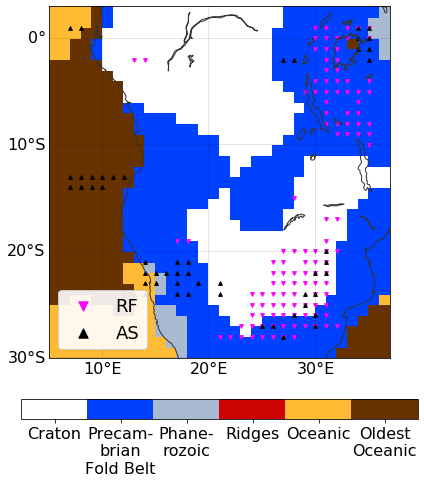

In [12]:
plot_reg(tec_units[:,0],tec_units[:,1],tec_units[:,2],seismic_stations_as,seismic_stations_rf,area_plot, 1,9)

Load Topography and gravity data

In [13]:
# Load and prepare topographic data
# Acknowledges Surface and Bedrock topography (based on ETOPO1, Amante & Eakins, 2009)
bed=np.loadtxt("ETOPO1_1degree_bed_global.txt")
bed2=np.copy(bed)
bed=cut_data_to_study_area(bed,area2)
bed=bed[np.lexsort((bed[:,0],bed[:,1]))]
ice=np.loadtxt("ETOPO1_1degree_ice_global.txt")
ice2=np.copy(ice)
ice=cut_data_to_study_area(ice,area2)
ice=ice[np.lexsort((ice[:,0],ice[:,1]))]


# Load gzz component of GOCE data
grav_data=np.loadtxt("gzz_1degree.txt")
grav_data2=np.copy(grav_data)
grav_data=cut_data_to_study_area(grav_data,area2)
grav_data=grav_data[np.lexsort((grav_data[:,0],grav_data[:,1]))]

#### Perform topographic correction
Creates a tesseroid model of topographic data, converts it to point masses and calculates the gravitational effect. The conversion of tesseroids to point masses and the forward calculation of the gravitational effect of point masses has been coded by Wolfgang Szwillus.

In [14]:
# Define coordinates and height for topographic correction with overlapping area
lon_grav=grav_data[:,0]
lat_grav=grav_data[:,1]
heights_grav=np.ones(len(lon_grav))*height_km*1000

In [15]:
topo_effect=topo_corr(lon_grav,lat_grav,bed,ice,heights_grav,point_mass_number)
bouguer=grav_data[:,2]-topo_effect

Calculate topographic effect
Calculate Jacobian
Calculation point mass No 0
-5.411714699691576 3.608591250652097


Cut Bouguer anomaly back to study area 

In [16]:
bouguer=np.vstack((bed[:,0],bed[:,1],bouguer)).T
bouguer=cut_data_to_study_area(bouguer,area)
bouguer=np.copy(bouguer[:,2])

Have a look at the calculated gravity data


In [17]:
# Define plot function. Takes longitude, latitude and data as vectors. Takes min and max value of colourbar and levels 
# as integers; takes label of colourbar as string  

def plot_data(lon, lat, data, vmin, vmax, levels, cblabel, ranges=True):
    plt.rcParams.update({'font.size': 16})
    x=np.arange(lon.min(),lon.max()+1,dx)
    y=np.arange(lat.min(),lat.max()+1,dy)
    X, Y = np.meshgrid(x, y)
    data=np.reshape(data,(len(y),len(x)))
    fig = plt.figure(figsize=(14, 7))
    bm.pcolor(X, Y, data, cmap=cm.jet, vmin=vmin, vmax=vmax)
    bm.drawmeridians(np.arange(-180, 180, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-80, 80, 10), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color='grey')
    m = plt.cm.ScalarMappable(cmap=cm.jet)
    m.set_array(data)
    m.set_clim(vmin, vmax)
    cb=plt.colorbar(m, boundaries=np.linspace(vmin, vmax, 25))
    cb.set_label(label='Eötvös [E]')
    plt.tight_layout(pad=0)

"Free air" vertical gravity gradient at 225 km height

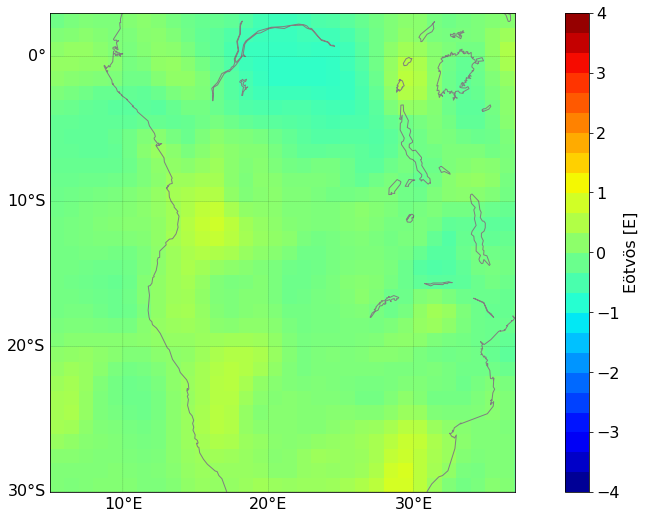

In [18]:
plot_data(lon_grav,lat_grav,grav_data[:,2],vmin=-4,vmax=4,levels=11, cblabel='Eötvös')

Topographic effect of vertical gravity gradient

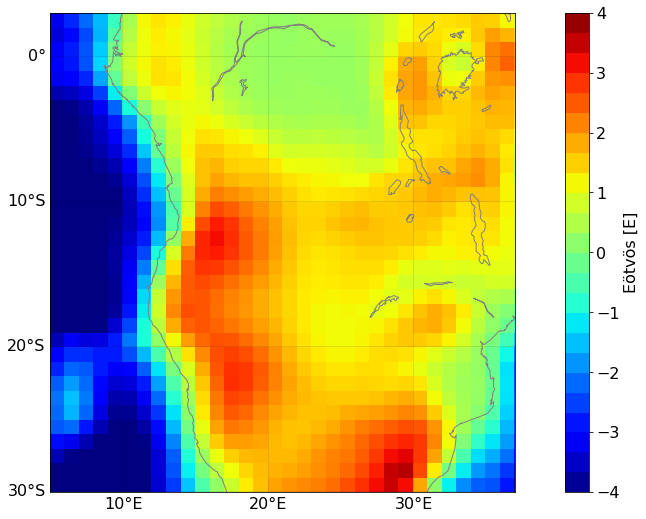

In [19]:
plot_data(lon_grav,lat_grav,topo_effect,vmin=-4,vmax=4,levels=11, cblabel='Eötvös')

Topo-corrected vertical gravity gradient

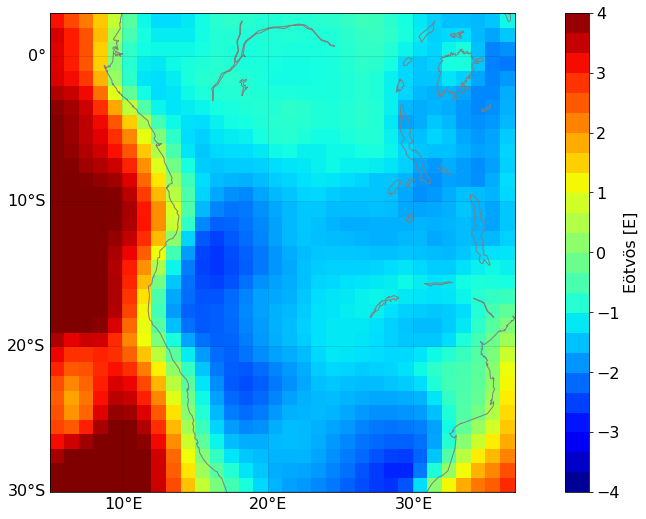

In [20]:
plot_data(lon,lat,bouguer,vmin=-4,vmax=4,levels=11, cblabel='Eötvös')

Inversion with single reference Moho depth and constant density contrast

The inversion of the gravity data is now performed once to obtain the reference Jacobian Matrix. 

In [21]:
# Create flat starting model
moho=np.ones(len(bouguer))*ref_moho

# Prepare layers of tesseroid model and define density contrast
(moho_top,moho_bottom,moho_top_shift,moho_bottom_shift)=construct_layers_for_gradient_inversion(ref_moho,moho) 
density=np.ones(lon.shape[0])*dens_init
density[moho < ref_moho] = -dens_init

# Calculate the Jacobian 
J,J_shift=create_Jacobian(lon,lat,component,moho_top,moho_bottom, moho_top_shift, moho_bottom_shift, 
                          heights, density, point_mass_number)


Calculate 1st Jacobian
Calculation point mass No 0
Calculate 2nd Jacobian
Calculation point mass No 0


In [22]:
save_fields="no"

# Reload the gravity data
data=np.vstack((lon,lat,bouguer)).T

# Define multiplicator of density contrasts for Jacobian Matrix
mult=np.copy(density)
mult=mult/dens_init

# Create progress bar
bar = progressbar.ProgressBar(maxval=len(dens_mat[:,0]), \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
print("Invert density contrasts")
print("Number of iterations:",len(dens_mat[:,0]))

Invert density contrasts
Number of iterations: 1296


First step of the gravity inversion:
Density contrasts for the non-cratonic units are varied according to the definition of the regionalization map. This is the computationally most intensive part of the program.

In [23]:
bar.start()
for i in range(0,len(dens_mat[:,0])): # Loop over all possible combinations of density contrasts
    bar.update(i+1)

    for m,mm in enumerate(np.unique(tec_units[:,2])): 
        ind=np.where(tec_units[:,2]==int(mm))
        density[ind]=dens_mat[i,int(m)]
    
    # Update the density contrasts for Jacobian Matrix
    density=np.abs(density)
    density=density*mult

    # Weight the Jacobian Matrix
    J_new,J_shift_new=weight_Jacobian(J,J_shift,density,dens_init)   

    # Invert the Moho depth, NOTE: calculation of fields is deprecated in this case
    moho_final,bouguer_fit=invert_and_calculate(data_name,moho,bouguer,J_new,J_shift_new,dmatrix,
                                                save_fields,mode,shape)

    moho_int=moho_final*1000

    # interpolate inverted Moho depth onto seismic stations
    moho_resid_points_as,interp_arr_as=interp_regular_grid_on_irregular_database(area,dx,moho_int,seismic_stations_as)
    moho_resid_points_rf,interp_arr_rf=interp_regular_grid_on_irregular_database(area,dx,moho_int,seismic_stations_rf)
    
    #Compute residual Moho depth (grid)
    moho_resid_grid=moho_final*-1 # residual Moho depth
    
    # Create RMS values of residual field and residual Moho depths and store them in a matrix
    rms_matrix_as=create_rms_matrix(rms_matrix_as,data,moho_resid_points_as,moho_resid_grid,i,bouguer_fit)
    rms_matrix_as[i,5:5+number_of_units]=dens_mat[i,0:number_of_units]
    rms_matrix_rf=create_rms_matrix(rms_matrix_rf,data,moho_resid_points_rf,moho_resid_grid,i,bouguer_fit)
    rms_matrix_rf[i,5:5+number_of_units]=dens_mat[i,0:number_of_units]

bar.finish()

[========================================================================] 100%


In [24]:
# Define quality factor and calculate RMS values for combined seismic estimates
Q=2
rms_matrix_as=rms_matrix_as[~(rms_matrix_as[:,0]==0)]
rms_matrix_rf=rms_matrix_rf[~(rms_matrix_rf[:,0]==0)]
rms_matrix_step1=np.vstack(((rms_matrix_as[:,1]*Q+rms_matrix_rf[:,1])/(Q+1),dens_mat.T)).T
rms_matrix_step1=rms_matrix_step1[np.lexsort((rms_matrix_step1[:,0],rms_matrix_step1[:,1]))]

Reload the regionalization to distinguish between individual cratons

In [25]:
tec_units_add=np.loadtxt("Reg_AF2019_n6_cratons_floodfill.txt")
tec_units_add=cut_data_to_study_area(tec_units_add,area)
tec_units_add=tec_units_add[np.lexsort((tec_units_add[:,0],tec_units_add[:,1]))]
tec_units_add[:,2]=tec_units_add[:,2]+6

idx=np.where((tec_units[:,2]==1) & (tec_units_add[:,2]<10))

tec_units[idx,2]=tec_units_add[idx,2]
number_of_units_add=np.unique(tec_units_add[:,2]).shape[0]-1
dens_mat_add=create_density_combinations(dens_range,number_of_units_add)


In [26]:
def plot_reg(lon, lat, data, seismic_stations1, seismic_stations2, area, vmin, vmax, cblabel='km', levels=60,ranges=True):
    plt.rcParams.update({'font.size': 16})
    data_copy=np.copy(data)
    data_copy[np.argwhere(data_copy<=6)]=np.nan
    x=np.arange(area[0],area[1]+1,dx)
    y=np.arange(area[2],area[3]+1,dy)
    X, Y = np.meshgrid(x, y)
    points=np.vstack((lon,lat)).T
    grid_z0 = griddata(points, data_copy, (X, Y), method='nearest')
    fig = plt.figure(figsize=(10, 7))
    ax = plt.subplot(111)
    bm.pcolor(X, Y, grid_z0, cmap=cmp_regionalization, vmin=vmin, vmax=vmax)
    bm.scatter(seismic_stations2[:,0],seismic_stations2[:,1],marker='v',s=14,color='magenta',label='RF')    
    bm.scatter(seismic_stations1[:,0],seismic_stations1[:,1],marker='^',s=14,color='k',label='AS')  
    bm.drawmeridians(np.arange(-180, 180, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-80, 80, 10), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    m = plt.cm.ScalarMappable(cmap=cmp_regionalization)
    m.set_array(data_copy)
    m.set_clim(vmin, vmax)
    labels=["Kalahari","Congo","West" + "\n" + "African"]
    cb=plt.colorbar(m,orientation="horizontal", boundaries=np.linspace(6.5, 9.5, 4),ticks=np.linspace(7,9,3),fraction=0.048, pad=0.1)
    cb.set_ticklabels(labels)
    leg=plt.legend(facecolor='white',loc=3,fancybox=True,fontsize=18,markerscale=2.5)
    leg.get_frame().set_alpha(0.9)
    plt.tight_layout()

Have a look at the regionalization map for cratons only

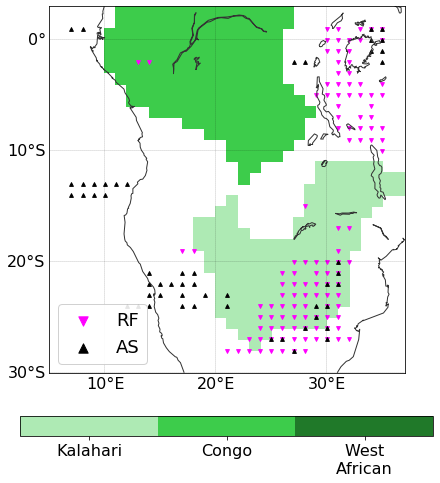

In [27]:
plot_reg(tec_units[:,0],tec_units[:,1],tec_units[:,2],seismic_stations_as,seismic_stations_rf,area_plot, 1,9)

In [28]:
# Prepare matrix of RMS values for next step
I = np.argsort(rms_matrix_step1[:,0]) 
rms_matrix_step1=rms_matrix_step1[I,:]
dens_mat=np.tile(rms_matrix_step1[0,2::],(len(dens_mat_add),1))
dens_mat=np.vstack((dens_mat.T,dens_mat_add.T)).T

rms_matrix_as=np.zeros((dens_range.size**(number_of_units_add),number_of_units_add+5))
rms_matrix_rf=np.copy(rms_matrix_as)

In [29]:
# Take the prefered density contrasts for the non-cratonic domains from the first step
for n,nn in enumerate(np.unique(tec_units[:,2])):
    if nn<=6:
        ind=np.where(tec_units[:,2]==int(nn))
        density[ind]=dens_mat[0,int(n)]

In [30]:
# Create progress bar
bar = progressbar.ProgressBar(maxval=len(dens_mat[:,0]), \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
print("Invert density contrasts")
print("Number of iterations:",len(dens_mat[:,0]))

Invert density contrasts
Number of iterations: 36


Second step of the inversion: Density contrasts for the individual cratonic units are varied. This step is much faster than the first one

In [31]:
rms_min=55
bar.start()
for i in range(0,len(dens_mat[:,0])): # Loop over all possible combinations of density contrasts
    bar.update(i+1)

    for m,mm in enumerate(np.unique(tec_units[:,2])): 
        if mm>6:
            ind=np.where(tec_units[:,2]==int(mm))
            density[ind]=dens_mat[i,int(m)]    

    # Update the density contrasts for Jacobian Matrix
    density=density*mult

    # Weight the Jacobian Matrix
    J_new,J_shift_new=weight_Jacobian(J,J_shift,density,dens_init)   

    # Invert the Moho depth, NOTE: calculation of fields is deprecated in this case
    moho_final,bouguer_fit=invert_and_calculate(data_name,moho,bouguer,J_new,J_shift_new,dmatrix,
                                                save_fields,mode,shape)

    moho_int=moho_final*1000

    # interpolate inverted Moho depth onto seismic stations
    moho_resid_points_as,interp_arr_as=interp_regular_grid_on_irregular_database(area,dx,moho_int,seismic_stations_as)
    moho_resid_points_rf,interp_arr_rf=interp_regular_grid_on_irregular_database(area,dx,moho_int,seismic_stations_rf)

    # Compute residual Moho depth (grid)
    moho_resid_grid=moho_final*-1 # residual Moho depth

    # Create RMS values of residual field and residual Moho depths and store them in a matrix
    rms_matrix_as=create_rms_matrix(rms_matrix_as,data,moho_resid_points_as,moho_resid_grid,i,bouguer_fit)
    rms_matrix_as[i,5:5+number_of_units_add]=dens_mat[i,0:number_of_units_add]
    rms_matrix_rf=create_rms_matrix(rms_matrix_rf,data,moho_resid_points_rf,moho_resid_grid,i,bouguer_fit)
    rms_matrix_rf[i,5:5+number_of_units_add]=dens_mat[i,0:number_of_units_add]  
    rms_as=(np.sqrt(np.sum(moho_resid_points_as**2)/(moho_resid_points_as.shape)))
    rms_rf=(np.sqrt(np.sum(moho_resid_points_rf**2)/(moho_resid_points_rf.shape)))
    rms_comb=(rms_matrix_as[i,1]*Q+rms_matrix_rf[i,1])/(Q+1)

    # Save inverted Moho depth and density contrasts
    if (rms_comb<rms_min):
        rms_min=np.copy(rms_comb)
        moho_save=np.array((lon,lat,moho_final*-1)).T
        density_save=np.array((lon,lat,density)).T
bar.finish()
rms_matrix_step2=np.vstack((((rms_matrix_as[:,1]*Q+rms_matrix_rf[:,1])/(Q+1)),dens_mat_add.T)).T

[========================================================================] 100%


Define new plotting functions for Moho depth and density contrasts

In [32]:
def plot_moho(lon, lat, data, area, vmin, vmax,cblabel='km', levels=60,ranges=True):
    plt.rcParams.update({'font.size': 16})
    dx=0.5
    dy=0.5
    x=np.arange(area[0],area[1]+dx,dx)
    y=np.arange(area[2],area[3]+dy,dy)
    X, Y = np.meshgrid(x, y)
    points=np.vstack((lon,lat)).T
    grid_z0 = griddata(points, data, (X, Y), method='linear')
    fig = plt.figure(figsize=(14, 7))
    bm.pcolor(X, Y, grid_z0, cmap=cmp_batlow, vmin=vmin, vmax=vmax)
        
    bm.drawmeridians(np.arange(-180, 180, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-80, 80, 10), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    m = plt.cm.ScalarMappable(cmap=cmp_batlow)
    m.set_array(data)
    m.set_clim(vmin, vmax)
    ticks=[np.arange(vmin,vmax+1,5)]
    cb=plt.colorbar(m, boundaries=np.linspace(vmin-2.5, vmax+2.5, 10),ticks=ticks)
    cb.set_label(label=cblabel)
    plt.tight_layout(pad=0)

In [33]:
def plot_densities(lon, lat, data, area, vmin, vmax, cblabel='kg/m³', levels=60,ranges=True):
    plt.rcParams.update({'font.size': 16})
    x=np.arange(area[0],area[1]+1,dx)
    y=np.arange(area[2],area[3]+1,dy)
    X, Y = np.meshgrid(x, y)
    points=np.vstack((lon,lat)).T
    grid_z0 = griddata(points, data, (X, Y), method='nearest')
    fig = plt.figure(figsize=(14, 7))
    bm.pcolor(X, Y, grid_z0, cmap=cmp_turku, vmin=vmin, vmax=vmax)
    bm.drawmeridians(np.arange(-180, 180, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-80, 80, 10), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    m = plt.cm.ScalarMappable(cmap=cmp_turku)
    m.set_array(data)
    m.set_clim(vmin, vmax)
    ticks=[np.arange(vmin,vmax+1,50)]
    cb=plt.colorbar(m, boundaries=np.linspace(vmin-25, vmax+25, 7),ticks=ticks)
    cb.set_label(label=cblabel)
    plt.tight_layout(pad=0)

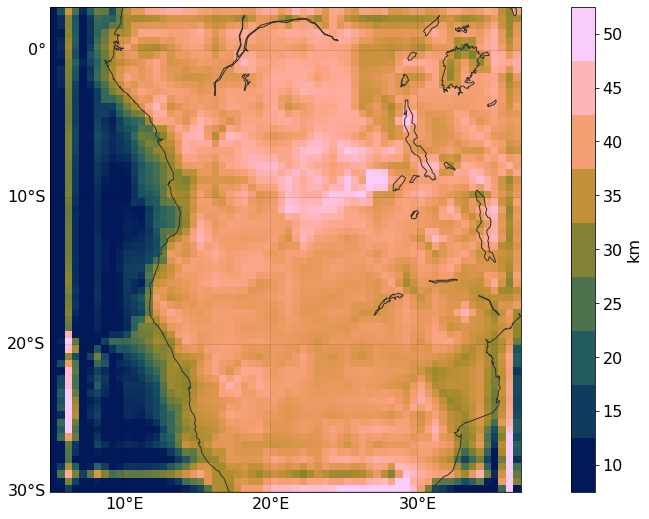

In [34]:
plot_moho(moho_save[:,0],moho_save[:,1],moho_save[:,2],area_plot, 10,50)

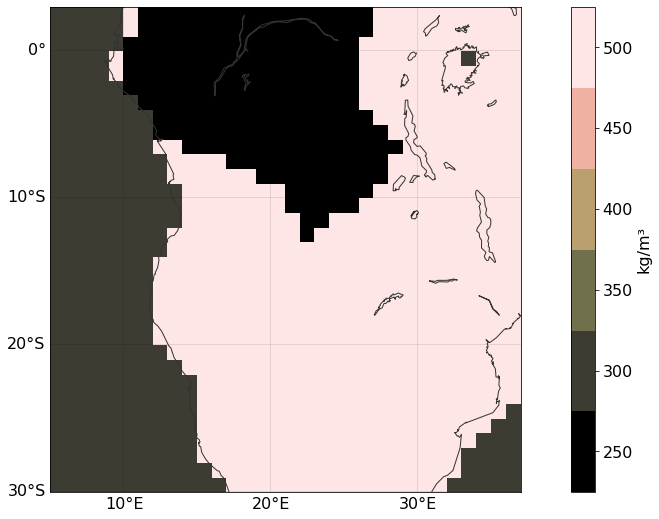

In [35]:
plot_densities(density_save[:,0],density_save[:,1],density_save[:,2],area_plot, 250,500)

Prepare individual distribution of density contrasts for each tectonic domain of Step 1

In [36]:
no_models=120 # select number of models to plot. Value should be less than 10% of all combinations 

In [37]:
values=np.around(np.arange(0,number_of_units-1,1))
dens_counts=np.zeros((0,2))
for i in values:
    unique, counts = np.unique(rms_matrix_step1[0:no_models,int(i)+2], return_counts=True)
    val=np.array((unique,counts)).T
    if val[0,0]!=dens_min:
        fill=np.arange(dens_min,val[0,0],dens_inc)
        fill=np.array((fill,np.zeros(len(fill)))).T
        val=np.concatenate((fill,val),axis=0)
    if val[-1,0]!=dens_max:
        fill=np.arange(val[-1,0]+dens_inc,dens_max+0.1,dens_inc)
        fill=np.array((fill,np.zeros(len(fill)))).T
        val=np.concatenate((val,fill),axis=0)
    dens_counts=np.append(dens_counts,val,axis=0)

Plot distribution of inverted density contrasts of Step 1

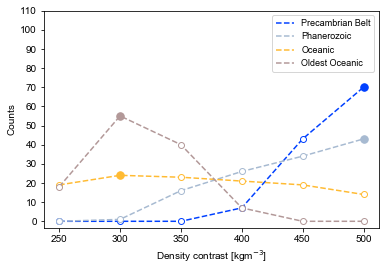

In [38]:
rgb_values=np.array(([61.0,204.0,75.0],[0.0,64.0,255.0],[167.0,186.0,209.0],
                     [204.0,3.0,0.0],[255.0,187.0,51.0],[178.0,152.0,152.0]))/255

fig,ax = plt.subplots()
labels=["Craton","Precambrian Belt","Phanerozoic","Ridges","Oceanic","Oldest Oceanic"]
for i,ii in enumerate(np.unique(tec_units[:,2])):
    if ((ii>1) and (ii<7)):
        comb=dens_counts[i*len(dens_range):len(dens_range)*(i+1),:]
        plt.plot(comb[:,0], comb[:,1], '--', color=(rgb_values[int(ii)-1]),label=labels[int(ii)-1])
        plt.plot(comb[:,0], comb[:,1], '.',markersize=12, color="white", markeredgecolor=(rgb_values[int(ii)-1]))
        plt.plot(comb[np.argmax(comb[:,1]),0],comb[np.argmax(comb[:,1]),1],'.',markersize=15,color=(rgb_values[int(ii)-1]))

ax.yaxis.set_minor_locator(MultipleLocator(100))
plt.xticks(dens_range,fontsize=10,fontname="Arial")
plt.yticks(np.arange(0,no_models,10),fontsize=10,fontname="Arial")
plt.xlabel('Density contrast [kgm$^{-3}$]',fontsize=10,fontname="Arial")
plt.ylabel('Counts',fontsize=10,fontname="Arial")
font = font_manager.FontProperties(family='Arial',size=9)
plt.legend(prop=font)
plt.show()

Prepare individual distribution of density contrasts for each tectonic domain of Step 2

In [39]:
# Prepare matrix of RMS values for next step
I = np.argsort(rms_matrix_step2[:,0]) 
rms_matrix_step2=rms_matrix_step2[I,:]

In [40]:
no_models=12 # select number of models to plot. Value should be less than 10% of all combinations 

In [41]:
values=np.around(np.arange(0,number_of_units_add+0.1-1,1))
dens_counts=np.zeros((0,2))
for i in values:
    unique, counts = np.unique(rms_matrix_step2[0:no_models,int(i)+1], return_counts=True)
    val=np.array((unique,counts)).T
    if val[0,0]!=dens_min:
        fill=np.arange(dens_min,val[0,0],dens_inc)
        fill=np.array((fill,np.zeros(len(fill)))).T
        val=np.concatenate((fill,val),axis=0)
    if val[-1,0]!=dens_max:
        fill=np.arange(val[-1,0]+dens_inc,dens_max+0.1,dens_inc)
        fill=np.array((fill,np.zeros(len(fill)))).T
        val=np.concatenate((val,fill),axis=0)
    dens_counts=np.append(dens_counts,val,axis=0)

Plot distribution of inverted density contrasts of Step 2

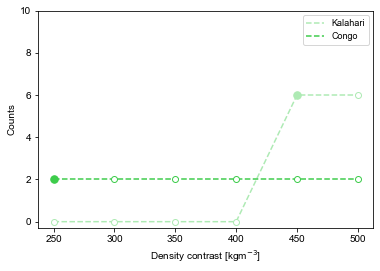

In [42]:
rgb_values=np.array(([174.0,234.0,180.0],[61.0,204.0,75.0],[32.0,121.0,41.0]))/255

fig,ax = plt.subplots()
labels=["Kalahari","Congo","West Africa"]

crat_ind=0
for i,ii in enumerate(np.unique(tec_units[:,2])):
    if ii>6:
        comb=dens_counts[crat_ind*len(dens_range):len(dens_range)*(crat_ind+1),:]
        plt.plot(comb[:,0], comb[:,1], '--', color=(rgb_values[int(ii)-7]),label=labels[int(ii)-7])
        plt.plot(comb[:,0], comb[:,1], '.',markersize=12, color="white", markeredgecolor=(rgb_values[int(ii)-7]))
        plt.plot(comb[np.argmax(comb[:,1]),0],comb[np.argmax(comb[:,1]),1],'.',markersize=15,color=(rgb_values[int(ii)-7]))
        crat_ind=crat_ind+1
ax.yaxis.set_minor_locator(MultipleLocator(100))
plt.xticks(dens_range,fontsize=10,fontname="Arial")
plt.yticks(np.arange(0,no_models,2),fontsize=10,fontname="Arial")
plt.xlabel('Density contrast [kgm$^{-3}$]',fontsize=10,fontname="Arial")
plt.ylabel('Counts',fontsize=10,fontname="Arial")
font = font_manager.FontProperties(family='Arial',size=9)
plt.legend(prop=font)
plt.show()